In [105]:
# Importing required libraries
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings('ignore')

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [22]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

imb_2019 = pd.read_csv("../data/merged_final_1h.csv", index_col=0, parse_dates=['dt_start_utc'], date_parser=dateparse)

In [23]:
def fill_missing(data):
    data = data.resample('1H').median()
    data = data.interpolate(method='time', limit_direction='both')
    return data

In [24]:
imb_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15336 entries, 2019-01-01 00:00:00 to 2020-09-30 23:00:00
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   windspeed_ms            15336 non-null  float64
 1   epex_da_de_eur_mwh      15336 non-null  float64
 2   solar_mw_fiftyhertz     15336 non-null  float64
 3   solar_mw_tennet         15336 non-null  float64
 4   solar_mw_amprion        15336 non-null  float64
 5   solar_mw_transnetbw     15336 non-null  float64
 6   solar_mw_nrv            15336 non-null  float64
 7   fc_da                   15336 non-null  float64
 8   fc_load_50H             15336 non-null  float64
 9   fc_load_DE              15336 non-null  float64
 10  fc_load_DK              15336 non-null  float64
 11  fc_load_DK1             15336 non-null  float64
 12  fc_load_TTG             15336 non-null  float64
 13  fc_solar_50H            15336 non-null  float64
 14  fc_

In [25]:
imb_2019

,windspeed_ms,epex_da_de_eur_mwh,solar_mw_fiftyhertz,solar_mw_tennet,solar_mw_amprion,solar_mw_transnetbw,solar_mw_nrv,fc_da,fc_load_50H,fc_load_DE,...,offshore_mw_nrv,onshore_mw_fiftyhertz,onshore_mw_tennet,onshore_mw_amprion,onshore_mw_transnetbw,onshore_mw_nrv,month,weekday,hour,imbalance_price_target
dt_start_utc,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,13.7925,10.07,0.0,0.00,0.0,0.0,0.00,29.730,6150.5,41218.5,...,5684.34,9231.31,11624.89,3039.50,105.45,24001.15,1,1,0,-3.465
2019-01-01 01:00:00,14.3600,-4.08,0.0,0.00,0.0,0.0,0.00,26.050,6029.0,40139.0,...,5334.19,10012.16,12762.32,3576.50,112.04,26463.02,1,1,1,-3.735
2019-01-01 02:00:00,15.0180,-9.91,0.0,0.00,0.0,0.0,0.00,23.760,6057.0,39917.0,...,5278.54,10852.08,13988.91,4094.75,164.29,29100.03,1,1,2,-9.250
2019-01-01 03:00:00,14.8220,-7.41,0.0,0.00,0.0,0.0,0.00,20.950,6122.5,40282.0,...,5160.90,11761.89,14809.73,4685.25,226.52,31483.39,1,1,3,11.355
2019-01-01 04:00:00,14.5930,-12.55,0.0,0.00,0.0,0.0,0.00,15.770,6152.0,40528.0,...,5001.96,13125.93,15131.73,5024.50,315.82,33597.98,1,1,4,-4.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,6.1635,49.92,0.0,0.03,0.0,0.0,0.03,53.555,11108.5,56709.0,...,4756.97,651.60,3648.29,1620.00,179.00,6098.89,9,2,19,16.450
2020-09-30 20:00:00,5.9385,42.79,0.0,0.05,0.0,0.0,0.05,46.200,10454.5,53241.0,...,5196.46,707.77,3953.82,1977.75,259.00,6898.34,9,2,20,26.050
2020-09-30 21:00:00,6.0630,35.02,0.0,0.05,0.0,0.0,0.05,40.030,9635.5,49149.0,...,5339.31,779.20,3957.25,2123.75,284.25,7144.45,9,2,21,56.265


In [26]:
def train_test_split(df):
    n = int(len(df)*0.7)
    train, test = df.iloc[:n], df.iloc[n:]

    return train,test

In [27]:
train_2019, test_2019 = train_test_split(imb_2019)
#train_2020, test_2020 = train_test_split(imb_2020)

In [28]:
print(train_2019.shape, test_2019.shape)
#print(train_2020.shape, test_2020.shape)

(10735, 38) (4601, 38)


In [29]:
def kpss_test(ts):
    """
    Performs a KPSS test for the null hypothesis of stationarity.
    
        Args:
        ts: 1d time series
        
        Returns:
        Summary of test statistic and critical values
    """
    print ('Results of KPSS Test:')
    kpsstest = kpss(ts, regression='c', nlags='legacy')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

def adf_test(ts):
    """
    Performs a Dickey-Fuller test for the null hypothesis of
    non-stationarity.
    
        Args:
        ts: 1-d time series
    
        Returns:
        Printed test statistic and critical values.
    """
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [30]:
print(kpss_test(train_2019[['imbalance_price_target']]))
print('null hypothesis kpss : Stationary data')
print(adf_test(train_2019[['imbalance_price_target']]))
print('null hypothesis adf : Non Stationary data')

Results of KPSS Test:
Test Statistic            1.809928
p-value                   0.010000
Lags Used                39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None
null hypothesis kpss : Stationary data
Results of Dickey-Fuller Test:
Test Statistic                -1.196206e+01
p-value                        4.080435e-22
#Lags Used                     3.000000e+01
Number of Observations Used    1.070400e+04
Critical Value (1%)           -3.430961e+00
Critical Value (5%)           -2.861810e+00
Critical Value (10%)          -2.566914e+00
dtype: float64
None
null hypothesis adf : Non Stationary data


kpss and adf results are contradictory one reason for that is the data is not stationary. Lets take a difference with the first lag and check again kpss and adf tests

In [31]:
def take_diff(df):
    diff = df - df.shift(1)
    diff.dropna(inplace=True)

    return diff


In [32]:
diff_train_2019 = take_diff(train_2019[['imbalance_price_target']])

In [33]:
diff_train_2019.head()

,imbalance_price_target
dt_start_utc,
2019-01-01 01:00:00,-0.270
2019-01-01 02:00:00,-5.515
2019-01-01 03:00:00,20.605
2019-01-01 04:00:00,-16.280
2019-01-01 05:00:00,1.445


In [34]:
print(kpss_test(diff_train_2019[['imbalance_price_target']]))
print('null hypothesis kpss : Stationary data')
print(adf_test(diff_train_2019[['imbalance_price_target']]))
print('null hypothesis adf : Non Stationary data')

Results of KPSS Test:
Test Statistic            0.005909
p-value                   0.100000
Lags Used                39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None
null hypothesis kpss : Stationary data
Results of Dickey-Fuller Test:
Test Statistic                   -24.341268
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    10694.000000
Critical Value (1%)               -3.430962
Critical Value (5%)               -2.861810
Critical Value (10%)              -2.566914
dtype: float64
None
null hypothesis adf : Non Stationary data


We can see now after substracting with its first lag, both kpss and adf tests varify that the data is now stationary. This also indicate the d value in ARIMA should be fix to 1.

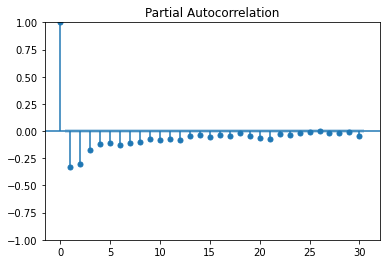

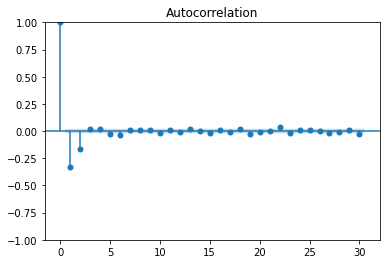

In [35]:
plot_pacf(diff_train_2019, lags=30, alpha=0.05)
plot_acf(diff_train_2019, lags=30, alpha=0.05);

Conclusion : AR (2), MA (2-4?)

In [36]:
p_range = range(1,4)
d_range = [0,1]
q_range = range(2,6)

In [37]:
def best_aic(df, p_range, d_range, q_range):
    aic = []
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                model = ARIMA(df, order=order)
                model_fit = model.fit()
                aic.append([order, model_fit.aic])
                print(order, model_fit.aic)
    return aic

In [38]:
aic = best_aic(train_2019[['imbalance_price_target']], p_range, d_range, q_range)

(1, 0, 2) 107430.64876292297
(1, 0, 3) 107424.28542198557
(1, 0, 4) 107398.9972283908
(1, 0, 5) 107359.13681472008
(1, 1, 2) 107492.98338836321
(1, 1, 3) 107409.89623452799
(1, 1, 4) 107415.88142493583
(1, 1, 5) 107409.91093855858
(2, 0, 2) 107416.55199340996
(2, 0, 3) 107386.41597966073
(2, 0, 4) 107371.08753842188
(2, 0, 5) 107358.52939700862
(2, 1, 2) 107484.99290250466
(2, 1, 3) 107413.00867169621
(2, 1, 4) 107416.51571968923
(2, 1, 5) 107411.6701462342
(3, 0, 2) 107405.84943056543
(3, 0, 3) 107382.04334827041
(3, 0, 4) 107367.66296420193
(3, 0, 5) 107355.11959278377
(3, 1, 2) 107410.01895129865
(3, 1, 3) 107403.65618518896
(3, 1, 4) 107420.52172644512
(3, 1, 5) 107420.03069908932


best parameters (1, 0, 5) 107359.13681472008 : NOTE that (3,0,5) has slightly less aic value however it is more expensive and the difference is quite less so we considered  (1,0,5) as the best parameter

## Check for seasonality

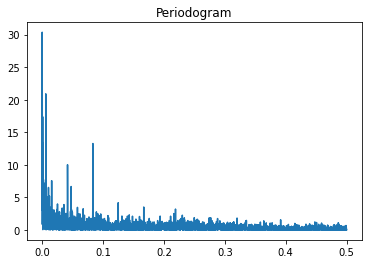

In [ ]:
from scipy import signal
# We use for the sampling frequency 1 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(imb_2019['imbalance_price_target'], fs = 1, window='hamming', scaling='spectrum')
plt.plot(f, Pxx)
plt.title('Periodogram')
plt.show();

In [ ]:
np.argsort(Pxx)[-20:]

array([  52,  730,   18,   42,   17,  239,   27,   86,   10,   14,    5,
        639,   23, 1278,    9,    3,   13,   91,    2,    1])

In [ ]:
1/f[np.argsort(Pxx)[-20:]]

array([2.94923077e+02, 2.10082192e+01, 8.52000000e+02, 3.65142857e+02,
       9.02117647e+02, 6.41673640e+01, 5.68000000e+02, 1.78325581e+02,
       1.53360000e+03, 1.09542857e+03, 3.06720000e+03, 2.40000000e+01,
       6.66782609e+02, 1.20000000e+01, 1.70400000e+03, 5.11200000e+03,
       1.17969231e+03, 1.68527473e+02, 7.66800000e+03, 1.53360000e+04])

### list of smallest periods
* 168
* 12
* 24

### Best ARIMA model so far
aic = best_aic(train_2019,(1,0,5))

In [41]:
pd.DataFrame(test_2019[['imbalance_price_target']].iloc[0]).T

,imbalance_price_target
2020-03-23 07:00:00,56.745


In [42]:
train_imb = train_2019[['imbalance_price_target']].copy()

In [46]:
model = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12),enforce_stationarity=False, enforce_invertibility=False,freq='H')
result = model.fit(maxiter=1000,disp=False)

In [47]:
#for i in range(len(test_2019)):
forecasts_1h = []
for i in range(len(test_2019)):
    forecast_1h = result.forecast(steps=1)
    result = result.extend(pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T)
    print(forecast_1h)
    forecasts_1h.append(forecast_1h)

2020-03-23 07:00:00   -12.6481
Freq: H, dtype: float64
2020-03-23 08:00:00    11.146997
Freq: H, dtype: float64
2020-03-23 09:00:00   -138.28546
Freq: H, dtype: float64
2020-03-23 10:00:00   -23.364567
Freq: H, dtype: float64
2020-03-23 11:00:00   -5.508424
Freq: H, dtype: float64
2020-03-23 12:00:00   -15.81874
Freq: H, dtype: float64
2020-03-23 13:00:00    22.892682
Freq: H, dtype: float64
2020-03-23 14:00:00    23.8781
Freq: H, dtype: float64
2020-03-23 15:00:00   -46.734177
Freq: H, dtype: float64
2020-03-23 16:00:00    2.892853
Freq: H, dtype: float64
2020-03-23 17:00:00    28.981921
Freq: H, dtype: float64
2020-03-23 18:00:00    25.771363
Freq: H, dtype: float64
2020-03-23 19:00:00   -14.606585
Freq: H, dtype: float64
2020-03-23 20:00:00   -44.401659
Freq: H, dtype: float64
2020-03-23 21:00:00    7.93628
Freq: H, dtype: float64
2020-03-23 22:00:00    1.210966
Freq: H, dtype: float64
2020-03-23 23:00:00    7.759788
Freq: H, dtype: float64
2020-03-24    16.505071
Freq: H, dtype: fl

In [48]:
def plot_forecast(test_df, forecast_list):
    forecast_df = test_df[['imbalance_price_target']]
    forecast_df['predicted'] = np.array(forecast_list)
    #print(forecast_df)

    #ploting
    plt.figure(figsize=(16, 8))
    
    plt.plot(forecast_df['imbalance_price_target'], label='actual')
    plt.plot(forecast_df['predicted'], label='predicted')
    plt.legend()
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Imbalace Price', fontsize=18)
    plt.title('Imbalance price ', fontsize=18)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    mse =mean_squared_error(forecast_df['imbalance_price_target'].values, forecast_df['predicted'].values)
    print('rmse = ', np.sqrt(mse));

rmse =  50.22046437427285


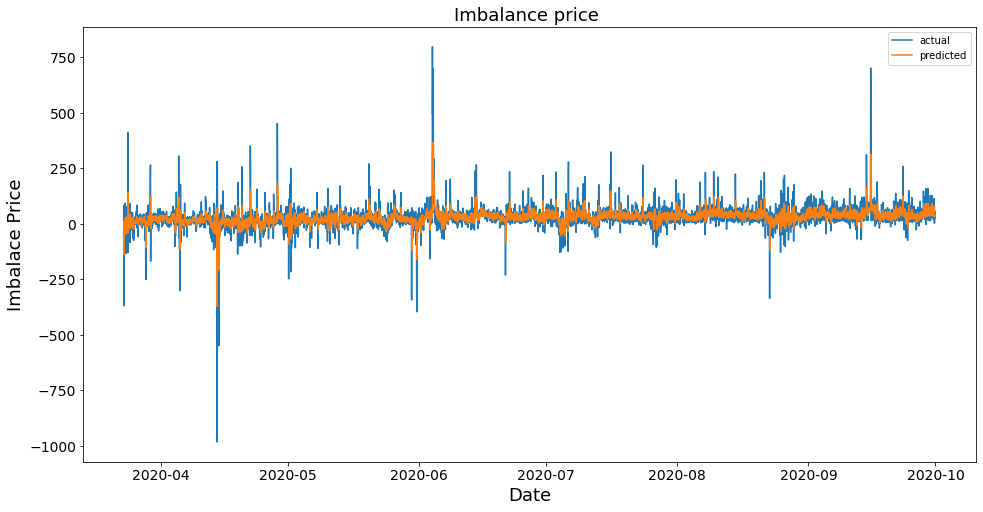

In [49]:
plot_forecast(test_2019, forecasts_1h)

In [71]:
train_2019['imbalance_price_target'].describe()

count    10735.000000
mean        35.755644
std         41.584037
min       -587.955000
25%         16.090000
50%         37.740000
75%         56.197500
max        484.945000
Name: imbalance_price_target, dtype: float64

In [74]:
np.abs(train_2019['imbalance_price_target']).describe()

count    10735.000000
mean        43.098341
std         33.914263
min          0.010000
25%         19.812500
50%         40.160000
75%         57.425000
max        587.955000
Name: imbalance_price_target, dtype: float64

In [75]:
train_2019

,windspeed_ms,epex_da_de_eur_mwh,solar_mw_fiftyhertz,solar_mw_tennet,solar_mw_amprion,solar_mw_transnetbw,solar_mw_nrv,fc_da,fc_load_50H,fc_load_DE,...,offshore_mw_nrv,onshore_mw_fiftyhertz,onshore_mw_tennet,onshore_mw_amprion,onshore_mw_transnetbw,onshore_mw_nrv,month,weekday,hour,imbalance_price_target
dt_start_utc,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,13.7925,10.07,0.00,0.00,0.00,0.00,0.00,29.73,6150.5,41218.5,...,5684.34,9231.31,11624.89,3039.50,105.45,24001.15,1,1,0,-3.465
2019-01-01 01:00:00,14.3600,-4.08,0.00,0.00,0.00,0.00,0.00,26.05,6029.0,40139.0,...,5334.19,10012.16,12762.32,3576.50,112.04,26463.02,1,1,1,-3.735
2019-01-01 02:00:00,15.0180,-9.91,0.00,0.00,0.00,0.00,0.00,23.76,6057.0,39917.0,...,5278.54,10852.08,13988.91,4094.75,164.29,29100.03,1,1,2,-9.250
2019-01-01 03:00:00,14.8220,-7.41,0.00,0.00,0.00,0.00,0.00,20.95,6122.5,40282.0,...,5160.90,11761.89,14809.73,4685.25,226.52,31483.39,1,1,3,11.355
2019-01-01 04:00:00,14.5930,-12.55,0.00,0.00,0.00,0.00,0.00,15.77,6152.0,40528.0,...,5001.96,13125.93,15131.73,5024.50,315.82,33597.98,1,1,4,-4.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-23 02:00:00,6.2520,9.28,0.00,0.00,0.00,0.00,0.00,17.89,8981.5,45302.0,...,6251.08,3569.82,6878.59,6509.50,1173.83,18131.74,3,0,2,18.235
2020-03-23 03:00:00,6.1365,9.28,0.00,0.00,0.00,0.00,0.00,18.07,9182.0,46831.0,...,6036.50,2959.46,6780.57,6311.25,1140.82,17192.10,3,0,3,18.085
2020-03-23 04:00:00,5.9565,12.76,3.00,0.00,0.00,0.00,3.00,23.93,9679.0,50419.5,...,5878.48,2476.55,6402.54,6277.00,1122.34,16278.43,3,0,4,36.700


In [76]:
forecast_test = test_2019[['imbalance_price_target']]

In [79]:
forecast_test['pred'] = np.array(forecasts_1h)

In [93]:
forecast_test['class'] = forecast_test['pred'].apply(lambda x: 0 if x < -100 else(1 if x < -5 else(2 if x <= 5 else(3 if x <= 100 else 4))))

In [128]:
def get_forecast_classification(forecast):
    # create dataframe of true and predicted values for both 2 classes and 5 classes
    forecast_df = test_2019[['imbalance_price_target']]
    forecast_df['price_pred'] = np.array(forecast)
    forecast_df['class_act_2c'] = forecast_df['imbalance_price_target'].apply(lambda x: 'neg' if x < 0 else 'pos')
    forecast_df['class_pred_2c'] = forecast_df['price_pred'].apply(lambda x: 'neg' if x < 0 else 'pos')
    forecast_df['class_act_5c'] = forecast_df['imbalance_price_target'].apply(lambda x: 'high neg' if x < -100 else('low neg' if x < -5 else('close to 0' if x <= 5 else('low pos' if x <= 100 else 'high pos'))))
    forecast_df['class_pred_5c'] = forecast_df['price_pred'].apply(lambda x: 'high neg' if x < -100 else('low neg' if x < -5 else('close to 0' if x <= 5 else('low pos' if x <= 100 else 'high pos'))))
    return forecast_df

In [129]:
test = get_forecast_classification(forecasts_1h)

In [130]:
test.head(20)

,imbalance_price_target,price_pred,class_act_2c,class_pred_2c,class_act_5c,class_pred_5c
dt_start_utc,,,,,,
2020-03-23 07:00:00,56.745,-12.648100,pos,neg,low pos,low neg
2020-03-23 08:00:00,-368.605,11.146997,neg,pos,high neg,low pos
2020-03-23 09:00:00,-88.885,-138.285460,neg,neg,low neg,high neg
2020-03-23 10:00:00,85.235,-23.364567,pos,neg,low pos,low neg
2020-03-23 11:00:00,40.500,-5.508424,pos,neg,low pos,low neg
2020-03-23 12:00:00,29.705,-15.818740,pos,neg,low pos,low neg
2020-03-23 13:00:00,51.920,22.892682,pos,pos,low pos,low pos
2020-03-23 14:00:00,-119.460,23.878100,neg,pos,high neg,low pos
2020-03-23 15:00:00,-17.230,-46.734177,neg,neg,low neg,low neg


In [ ]:
test['imbalance_price_target']

In [131]:
test

,imbalance_price_target,price_pred,class_act_2c,class_pred_2c,class_act_5c,class_pred_5c
dt_start_utc,,,,,,
2020-03-23 07:00:00,56.745,-12.648100,pos,neg,low pos,low neg
2020-03-23 08:00:00,-368.605,11.146997,neg,pos,high neg,low pos
2020-03-23 09:00:00,-88.885,-138.285460,neg,neg,low neg,high neg
2020-03-23 10:00:00,85.235,-23.364567,pos,neg,low pos,low neg
2020-03-23 11:00:00,40.500,-5.508424,pos,neg,low pos,low neg
...,...,...,...,...,...,...
2020-09-30 19:00:00,16.450,32.341874,pos,pos,low pos,low pos
2020-09-30 20:00:00,26.050,34.335756,pos,pos,low pos,low pos
2020-09-30 21:00:00,56.265,33.185412,pos,pos,low pos,low pos


In [132]:
def classification_summary(forecast_df):
    cm2 = confusion_matrix(forecast_df['class_act_2c'], forecast_df['class_pred_2c'])
    cm5 = confusion_matrix(forecast_df['class_act_5c'], forecast_df['class_pred_5c'])
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
    fig.suptitle('---Confusion matrices---')
    axes[0].set_title('2 class - classification')
    axes[1].set_title('5 class - classification')
    sns.heatmap(ax=axes[0], data=cm2, annot=True, fmt='g')
    sns.heatmap(ax=axes[1], data=cm5, annot=True, fmt='g')
    print('Classification report')
    print(classification_report(forecast_df['class_act_2c'], forecast_df['class_pred_2c']))
    print(classification_report(forecast_df['class_act_5c'], forecast_df['class_pred_5c']))

Classification report
              precision    recall  f1-score   support

         neg       0.58      0.29      0.39       807
         pos       0.86      0.96      0.91      3794

    accuracy                           0.84      4601
   macro avg       0.72      0.62      0.65      4601
weighted avg       0.81      0.84      0.82      4601

              precision    recall  f1-score   support

  close to 0       0.14      0.09      0.11       409
    high neg       0.12      0.02      0.04        41
    high pos       0.52      0.10      0.17       216
     low neg       0.52      0.26      0.35       595
     low pos       0.78      0.93      0.85      3340

    accuracy                           0.72      4601
   macro avg       0.42      0.28      0.30      4601
weighted avg       0.67      0.72      0.68      4601



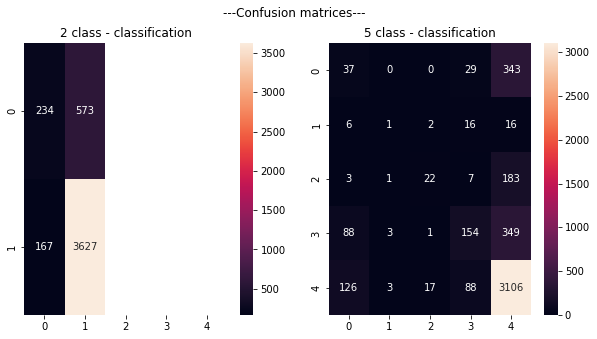

In [133]:
classification_summary(test)

In [103]:
cm = confusion_matrix(forecast_df_1h['class_act'], forecast_df_1h['class_pred'])

<AxesSubplot:>

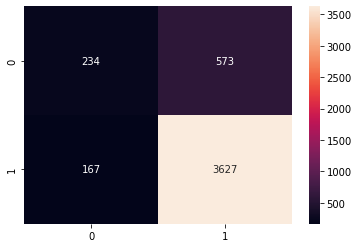

In [104]:
sns.heatmap(cm, annot=True, fmt='g')

In [362]:
print(classification_report(forecast_df_1h['class_act'], forecast_df_1h['class_pred']))

              precision    recall  f1-score   support

           0       0.58      0.29      0.39       807
           1       0.86      0.96      0.91      3794

    accuracy                           0.84      4601
   macro avg       0.72      0.62      0.65      4601
weighted avg       0.81      0.84      0.82      4601



In [ ]:
test['class_act'] = (np.sign(test['1']).values)
test['class_pred'] = (np.sign(test['1h']).values)

## 6 hour focecast

In [235]:
model_6h = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12),enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_6h = model_6h.fit(maxiter=1000,disp=False)

In [239]:
pd.DataFrame(test_2019[['imbalance_price_target']].iloc[0:0+6])

,imbalance_price_target
dt_start_utc,
2020-03-23 07:00:00,56.745
2020-03-23 08:00:00,-368.605
2020-03-23 09:00:00,-88.885
2020-03-23 10:00:00,85.235
2020-03-23 11:00:00,40.500
2020-03-23 12:00:00,29.705


In [280]:
result_6h_bkp.forecast(steps=6).values

array([11.14699745,  5.25764394, 13.90325022,  7.19548412, -3.78360922,
        3.42321143])

In [283]:
forecasts_6h = []
for i in range(0,len(test_2019),6):
    forecast_6h = result_6h.forecast(steps=6)
    result_6h = result_6h.extend(pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i:i+6]))
    print(forecast_6h)
    forecasts_6h.append(forecast_6h.values)

2020-03-23 07:00:00   -12.648100
2020-03-23 08:00:00   -15.083019
2020-03-23 09:00:00    -4.964565
2020-03-23 10:00:00     2.750936
2020-03-23 11:00:00    -2.555653
2020-03-23 12:00:00    -9.066521
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 13:00:00    22.892682
2020-03-23 14:00:00    12.906015
2020-03-23 15:00:00     3.170458
2020-03-23 16:00:00     8.190428
2020-03-23 17:00:00     9.495394
2020-03-23 18:00:00    14.859818
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 19:00:00   -14.606585
2020-03-23 20:00:00     0.894377
2020-03-23 21:00:00    -1.209562
2020-03-23 22:00:00    -1.912428
2020-03-23 23:00:00    -2.199310
2020-03-24 00:00:00    -7.708964
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 01:00:00     8.787712
2020-03-24 02:00:00     9.897893
2020-03-24 03:00:00     6.981756
2020-03-24 04:00:00    10.167018
2020-03-24 05:00:00    12.375934
2020-03-24 06:00:00    12.978370
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 07:00:00    -

In [297]:
forecasts_6h = np.array(forecasts_6h).reshape(-1,1)
forecasts_6h = forecasts_6h[:-1]

In [291]:
test_2019.shape

(4601, 38)

In [298]:
len(forecasts_6h)

4601

rmse =  53.36357316136339


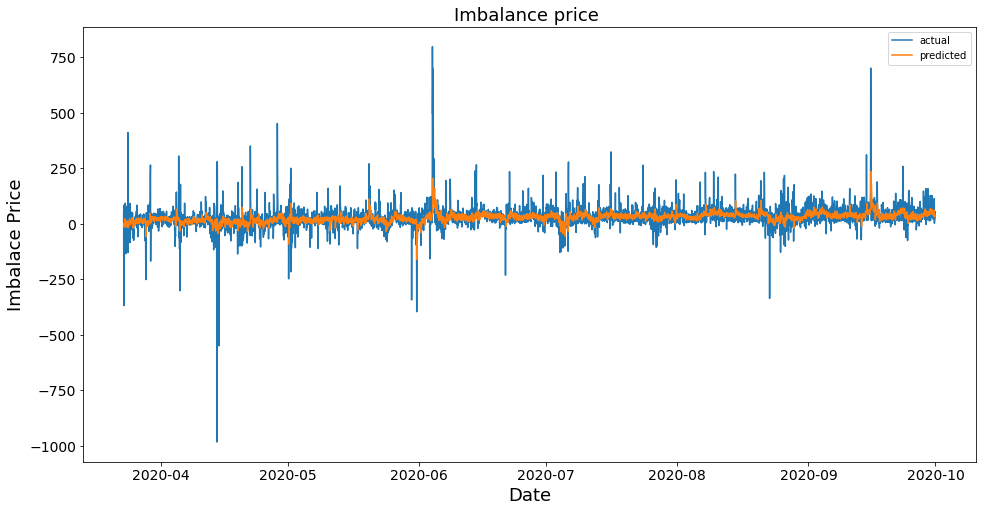

In [299]:
plot_forecast(test_2019, forecasts_6h)

## WITH forecast_day_ahead feature as additional feature

In [316]:
model_2f = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12),exog = train_2019[['fc_da']], enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_2f = model_2f.fit(maxiter=1000,disp=False)

In [317]:
result_2f_bkup = result_2f

In [334]:
#for i in range(len(test_2019)):
forecasts_2f_1h = []
forecast_1h = result_2f_bkup.forecast(steps=1, exog = train_2019[['fc_da']].iloc[-1])
forecasts_2f_1h.append(forecast_1h)
for i in range(len(test_2019)):
    result_2f_bkup = result_2f_bkup.extend(endog = pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T.values, exog = pd.DataFrame(test_2019[['fc_da']].iloc[i]).T.values)
    forecast_1h = result_2f_bkup.forecast(steps=1, exog = test_2019[['fc_da']].iloc[i])
    print(forecast_1h)
    forecasts_2f_1h.append(forecast_1h)

2020-03-23 08:00:00    22.325105
Freq: H, dtype: float64
2020-03-23 09:00:00   -126.446033
Freq: H, dtype: float64
2020-03-23 10:00:00   -14.373028
Freq: H, dtype: float64
2020-03-23 11:00:00    3.969544
Freq: H, dtype: float64
2020-03-23 12:00:00   -2.512779
Freq: H, dtype: float64
2020-03-23 13:00:00    23.099845
Freq: H, dtype: float64
2020-03-23 14:00:00    23.774529
Freq: H, dtype: float64
2020-03-23 15:00:00   -38.990409
Freq: H, dtype: float64
2020-03-23 16:00:00    5.339085
Freq: H, dtype: float64
2020-03-23 17:00:00    31.234301
Freq: H, dtype: float64
2020-03-23 18:00:00    33.390961
Freq: H, dtype: float64
2020-03-23 19:00:00    0.878602
Freq: H, dtype: float64
2020-03-23 20:00:00   -37.34747
Freq: H, dtype: float64
2020-03-23 21:00:00    13.485645
Freq: H, dtype: float64
2020-03-23 22:00:00    6.664701
Freq: H, dtype: float64
2020-03-23 23:00:00    12.972962
Freq: H, dtype: float64
2020-03-24    24.380204
Freq: H, dtype: float64
2020-03-24 01:00:00    5.295135
Freq: H, dtyp

In [336]:
test_2019.shape

(4601, 38)

In [337]:
len(forecasts_2f_1h)

4602

In [344]:
forecasts_2f_1h = forecasts_2f_1h[:-1]

rmse =  50.20358657866356


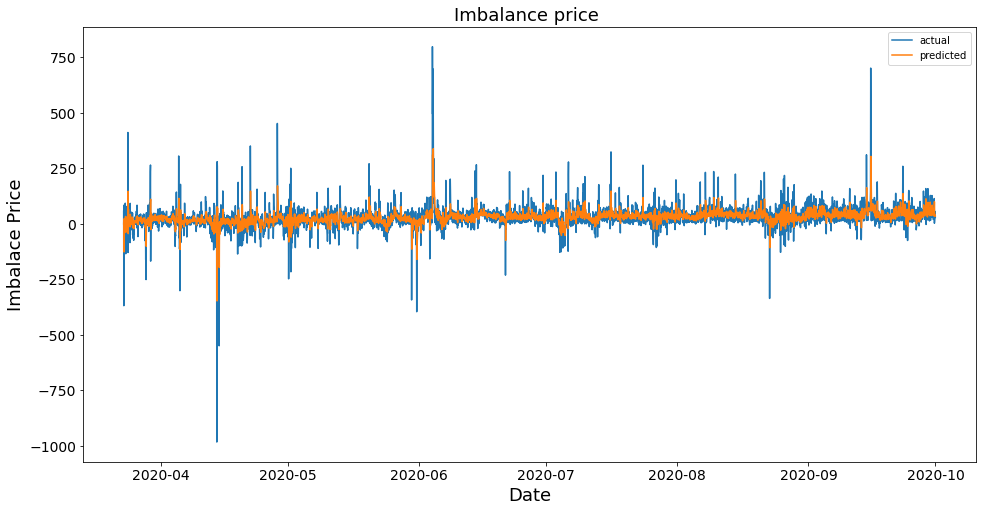

In [345]:
plot_forecast(test_2019, forecasts_2f_1h)

## 6 Hour Forcast with day ahead forecast as additional feature

In [369]:
model_6h_2f = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12), exog = train_2019[['fc_da']], enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_6h_2f = model_6h_2f.fit(maxiter=1000,disp=False)

In [ ]:
#for i in range(len(test_2019)):
forecasts_6h_2f = []
forecast_6h = result_6h_2f.forecast(steps=6, exog = train_2019[['fc_da']].iloc[-1])
forecasts_2f_1h.append(forecast_1h)
for i in range(0,len(test_2019),6):
    result_6h_2f = result_6h_2f.extend(endog = pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T.values, exog = pd.DataFrame(test_2019[['fc_da']].iloc[i]).T.values)
    forecast_6h = result_6h_2f.forecast(steps=6, exog = test_2019[['fc_da']].iloc[i:i+6])
    print(forecast_1h)
    forecasts_2f_1h.append(forecast_1h)

In [ ]:
#Create a dataframe which contain the target and predicted values

def plot_prediction(df)
forecast_1h_df = test_2019[['imbalance_price_target']]
forecast_1h_df['predicted'] = np.array(forecasts_1h)

plt.figure(figsize=(16, 12))
#plt.plot(train_2019.iloc[-250:-98], label='train')
plt.plot(forecast_1h_df['imbalance_price_target'], label='actual')
plt.plot(forecast_1h_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);

In [141]:
#for i in range(len(test_2019)):
forecasts_1h = []
for i in range(len(test_2019)):
    train_imb = pd.concat([train_imb, pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T])
    model_1h = ARIMA(train_imb, order=(1,0,5))
    forecast_1h = model_1h_fit.forecast(steps=1)
    print(forecast_1h)
    forecasts_1h.append(forecast_1h)
    if i == 10:
        break

2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64


In [96]:
forecast_1h_df = train_modified.iloc[-98:-1]
forecast_1h_df['predicted'] = np.array(forecasts_1h)

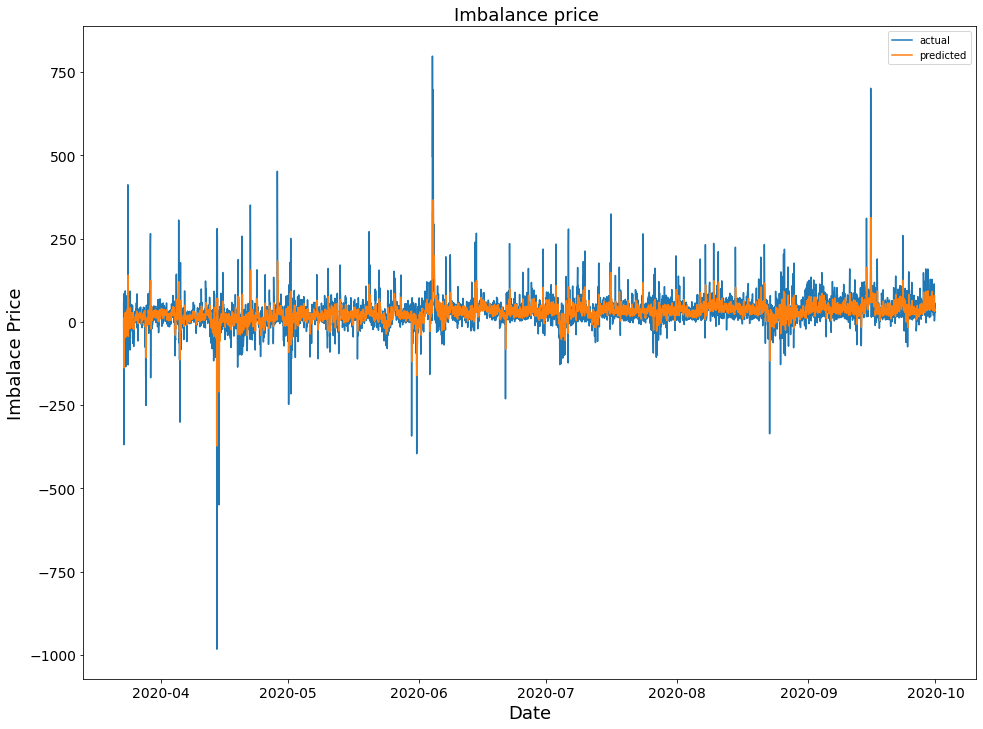

In [189]:
plt.figure(figsize=(16, 12))
#plt.plot(train_2019.iloc[-250:-98], label='train')
plt.plot(forecast_1h_df['imbalance_price_target'], label='actual')
plt.plot(forecast_1h_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
plt.savefig('imb_price_train_test_arima_1h.png')

In [192]:
np.sqrt(mean_squared_error(forecast_1h_df['imbalance_price_target'].values, forecast_1h_df['predicted'].values))

50.22046437427285

In [193]:
len(forecast_1h_df)

4601

In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error())

In [28]:
#for i in range(len(test_2019)):
forecasts_6h = []
for i in range(0,24,6):
    model_6h = ARIMA(train_2019.iloc[:-(25-i),:], order=(2,1,7))
    model_6h_fit = model_6h.fit()
    forecast_6h = model_6h_fit.forecast(steps=6)
    print(forecast_6h)
    forecasts_6h.append(forecast_6h.values)

2020-08-17 15:00:00    457.938858
2020-08-17 16:00:00    215.031158
2020-08-17 17:00:00    186.804066
2020-08-17 18:00:00    154.360982
2020-08-17 19:00:00    110.536118
2020-08-17 20:00:00    105.468761
Freq: H, Name: predicted_mean, dtype: float64
2020-08-17 21:00:00      7.779984
2020-08-17 22:00:00    125.419474
2020-08-17 23:00:00    131.720098
2020-08-18 00:00:00    108.379550
2020-08-18 01:00:00    120.265317
2020-08-18 02:00:00    121.496040
Freq: H, Name: predicted_mean, dtype: float64
2020-08-18 03:00:00   -12.578646
2020-08-18 04:00:00    26.210504
2020-08-18 05:00:00    48.630590
2020-08-18 06:00:00    75.986324
2020-08-18 07:00:00    80.562780
2020-08-18 08:00:00    82.297769
Freq: H, Name: predicted_mean, dtype: float64
2020-08-18 09:00:00   -142.857622
2020-08-18 10:00:00    -43.296123
2020-08-18 11:00:00    -17.782585
2020-08-18 12:00:00     24.525237
2020-08-18 13:00:00     46.281686
2020-08-18 14:00:00     49.894842
Freq: H, Name: predicted_mean, dtype: float64


In [29]:
forecasts_6h = np.array(forecasts_6h).reshape(24,1)

In [30]:
forecast_6h_df = train_2019.iloc[-25:-1]
forecast_6h_df['predicted'] = np.array(forecasts_6h)

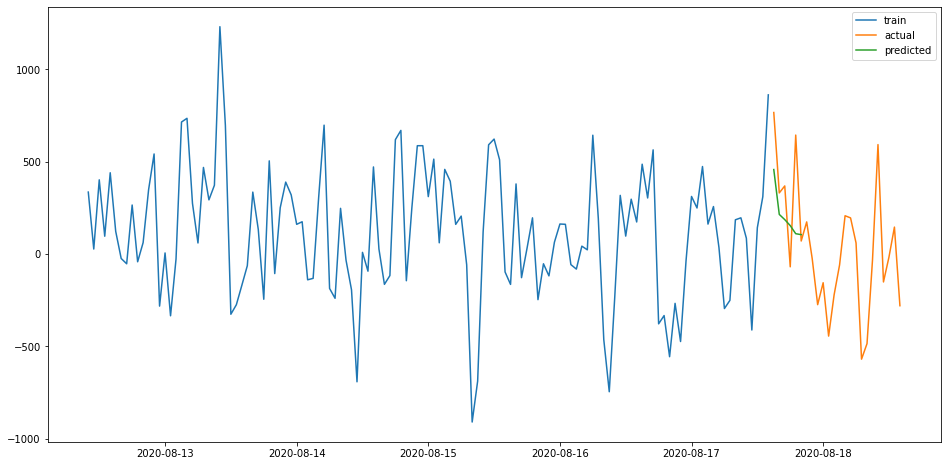

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[:6], label='predicted')
plt.legend()

Index(['fiftyhertz', 'tennet', 'amprion', 'transnetbw', 'nrv'], dtype='object')

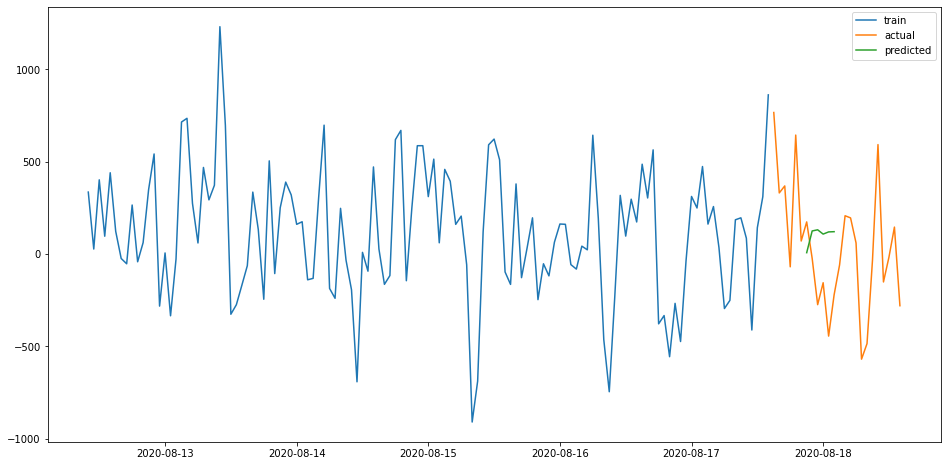

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[6:12], label='predicted')
plt.legend()

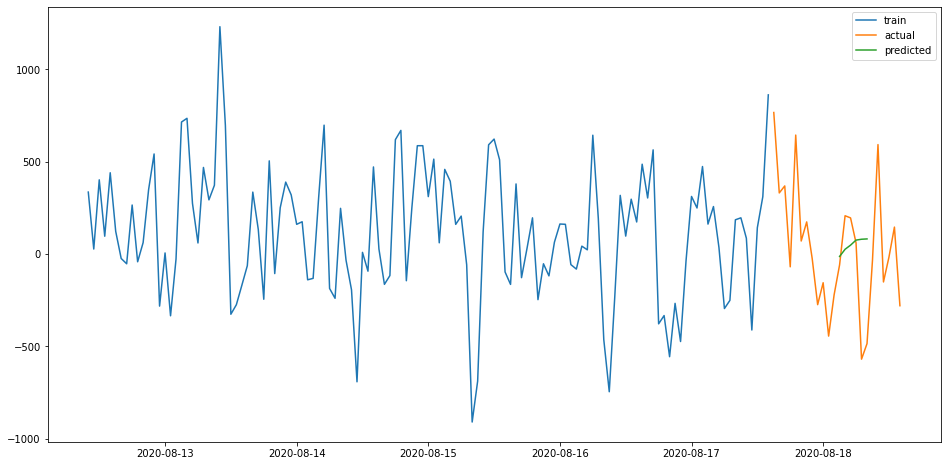

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[12:18], label='predicted')
plt.legend()

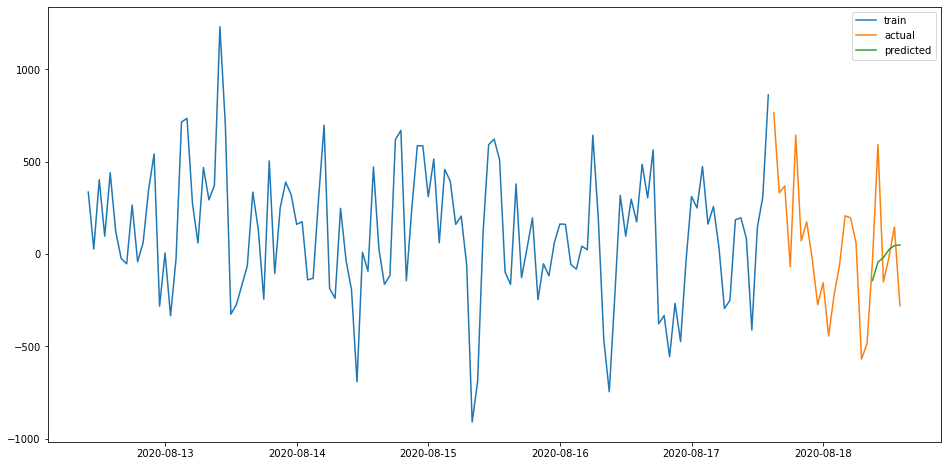

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[18:], label='predicted')
plt.legend()

In [ ]:
# or parameters of the model (fit_intercept for Linear Regression model)
mlflow_params = {
      "p": fitted_model.params,
      "d": ,
      "q": ,
  }

In [ ]:
# logging params to mlflow
mlflow.log_params(params)
# setting tags
mlflow.set_tag("model", "ARIMA")
mlflow.set_tag("features", "imbalance price")
# logging metrics
mlflow.log_metric("test-" + "RMSE", rmse)
mlflow.log_metric("test-" + "R2", rsquared)
# end run
mlflow.end_run()

In [ ]:
plt.figure(figsize=(14,6))
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals, label='residuals')
#plt.plot(train_2019, label= 'original', alpha=0.5)
plt.legend()

## Without outliers

In [139]:
train_2019_nooutlier = train_2019[(train_2019 >= train_2019.quantile(0.05)) & (train_2019 <= train_2019.quantile(0.95))]

In [142]:
train_2019_nooutlier.head()

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150


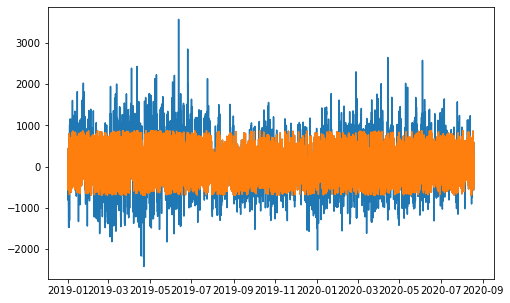

In [166]:
plt.figure(figsize=(8,5))
plt.plot(train_2019)
plt.plot(train_2019_nooutlier)

In [143]:
train_2019_nooutlier = fill_missing(train_2019_nooutlier)

In [144]:
train_2019_nooutlier

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150
...,...
2020-08-18 11:00:00,-150.6755
2020-08-18 12:00:00,-16.4735
2020-08-18 13:00:00,146.3290


In [145]:
kpss_test(train_2019_nooutlier)

Results of KPSS Test:
Test Statistic            1.233565
p-value                   0.010000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [146]:
adf_test(train_2019_nooutlier)

Results of Dickey-Fuller Test:
Test Statistic                -1.569009e+01
p-value                        1.437384e-28
#Lags Used                     3.000000e+01
Number of Observations Used    1.426500e+04
Critical Value (1%)           -3.430808e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [149]:
diff_train_2019_nooutlier = take_diff(train_2019_nooutlier)

In [150]:
kpss_test(diff_train_2019_nooutlier)

Results of KPSS Test:
Test Statistic            0.002075
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [151]:
adf_test(diff_train_2019_nooutlier)

Results of Dickey-Fuller Test:
Test Statistic                   -28.716000
p-value                            0.000000
#Lags Used                        42.000000
Number of Observations Used    14252.000000
Critical Value (1%)               -3.430809
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


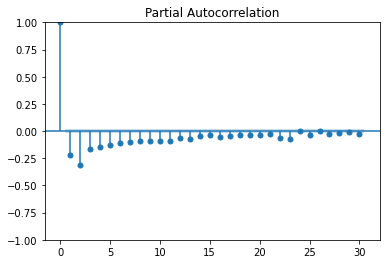

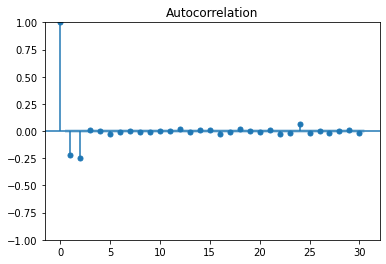

In [152]:
plot_pacf(diff_train_2019, lags=30, alpha=0.05)
plot_acf(diff_train_2019, lags=30, alpha=0.05);

In [156]:
#for i in range(len(test_2019)):
forecasts_1h_nooutlier = []
for i in range(24):
    model_1h_nooutlier = ARIMA(train_2019_nooutlier.iloc[:-(25-i),:], order=(2,1,6))
    model_1h_fit_nooutlier = model_1h_nooutlier.fit()
    forecast_1h_nooutlier = model_1h_fit_nooutlier.forecast(steps=1)
    print(forecast_1h_nooutlier)
    forecasts_1h_nooutlier.append(forecast_1h_nooutlier)

2020-08-17 15:00:00    413.767378
Freq: H, dtype: float64
2020-08-17 16:00:00    344.820749
Freq: H, dtype: float64
2020-08-17 17:00:00    190.612087
Freq: H, dtype: float64
2020-08-17 18:00:00    217.200977
Freq: H, dtype: float64
2020-08-17 19:00:00    21.701165
Freq: H, dtype: float64
2020-08-17 20:00:00    368.968817
Freq: H, dtype: float64
2020-08-17 21:00:00    62.772299
Freq: H, dtype: float64
2020-08-17 22:00:00    180.215036
Freq: H, dtype: float64
2020-08-17 23:00:00    35.936889
Freq: H, dtype: float64
2020-08-18   -32.638875
Freq: H, dtype: float64
2020-08-18 01:00:00    2.062458
Freq: H, dtype: float64
2020-08-18 02:00:00   -135.788368
Freq: H, dtype: float64
2020-08-18 03:00:00   -28.193423
Freq: H, dtype: float64
2020-08-18 04:00:00    10.324714
Freq: H, dtype: float64
2020-08-18 05:00:00    134.084868
Freq: H, dtype: float64
2020-08-18 06:00:00    112.348211
Freq: H, dtype: float64
2020-08-18 07:00:00    65.309703
Freq: H, dtype: float64
2020-08-18 08:00:00   -212.63237

In [158]:
forecast_1h_nooutlier_df = train_2019.iloc[-25:-1]
forecast_1h_nooutlier_df['predicted'] = np.array(forecasts_1h_nooutlier)

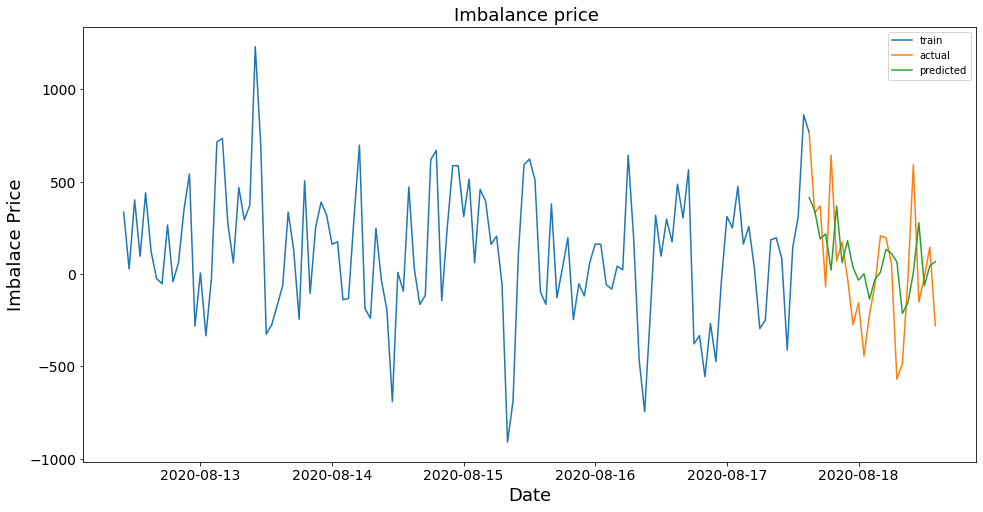

In [159]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-24], label='train')
plt.plot(forecast_1h_nooutlier_df['imbalance_price'], label='actual')
plt.plot(forecast_1h_nooutlier_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);


In [161]:
np.sqrt(mean_squared_error(forecast_1h_nooutlier_df['imbalance_price'].values, forecast_1h_nooutlier_df['predicted'].values))

308.3407719901207

## SHORTER DATA

In [179]:
train_2019

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150
...,...
2020-08-18 11:00:00,-150.6755
2020-08-18 12:00:00,-16.4735
2020-08-18 13:00:00,146.3290


In [186]:
train_jan = train_2019[(train_2019.index >= '2019-01-01 00:00:00') & (train_2019.index < '2019-02-01 00:00:00')]
train_feb = train_2019[(train_2019.index >= '2019-02-01 00:00:00') & (train_2019.index < '2019-03-01 00:00:00')]
train_june = train_2019[(train_2019.index >= '2019-06-01 00:00:00') & (train_2019.index < '2019-08-01 00:00:00')]
train_sep = train_2019[(train_2019.index >= '2019-09-01 00:00:00') & (train_2019.index < '2019-11-01 00:00:00')]
train_oct = train_2019[(train_2019.index >= '2019-10-01 00:00:00') & (train_2019.index < '2019-12-01 00:00:00')]

In [190]:
kpss_test(train_jan)

Results of KPSS Test:
Test Statistic            0.221805
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [193]:
kpss_test(train_oct)

Results of KPSS Test:
Test Statistic            0.103878
p-value                   0.100000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [192]:
adf_test(train_jan)

Results of Dickey-Fuller Test:
Test Statistic                -9.234495e+00
p-value                        1.644381e-15
#Lags Used                     2.000000e+00
Number of Observations Used    7.410000e+02
Critical Value (1%)           -3.439206e+00
Critical Value (5%)           -2.865448e+00
Critical Value (10%)          -2.568851e+00
dtype: float64


In [194]:
adf_test(train_oct)

Results of Dickey-Fuller Test:
Test Statistic                -1.232007e+01
p-value                        6.782405e-23
#Lags Used                     4.000000e+00
Number of Observations Used    1.459000e+03
Critical Value (1%)           -3.434840e+00
Critical Value (5%)           -2.863523e+00
Critical Value (10%)          -2.567826e+00
dtype: float64


In [198]:
dif_train_jan = take_diff(train_jan)
dif_train_june = take_diff(train_june)

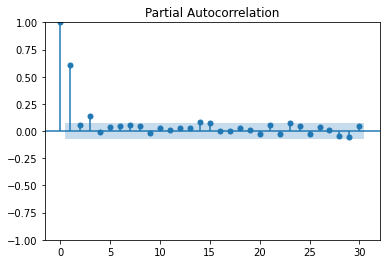

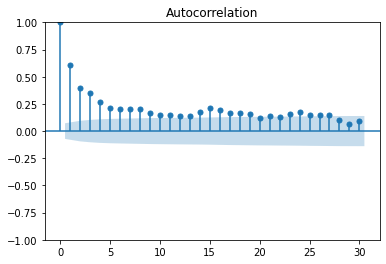

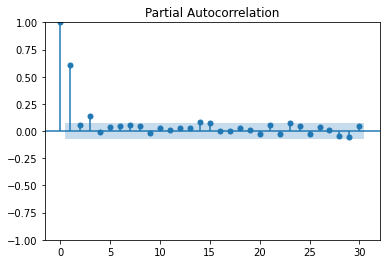

In [236]:
plot_acf(train_jan, lags=30, alpha=0.05)
plot_pacf(train_jan, lags=30, alpha=0.05)

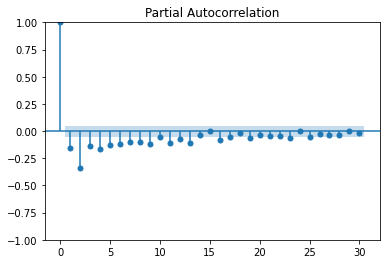

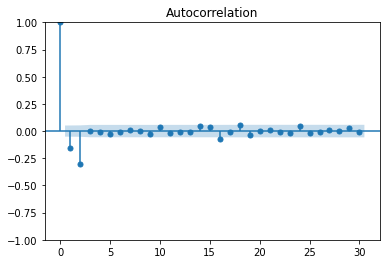

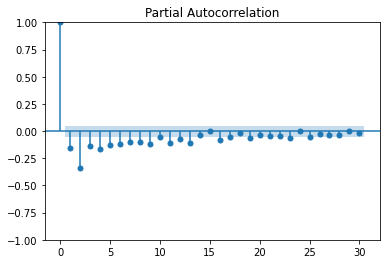

In [199]:
plot_acf(dif_train_june, lags=30, alpha=0.05)
plot_pacf(dif_train_june, lags=30, alpha=0.05)

In [200]:
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)

In [201]:
aic_jan = best_aic(train_jan, p_range, d_range, q_range)


(1, 1, 1) 11055.577832263341
(1, 1, 2) 11057.457718835736
(1, 1, 3) 11054.863367386844
(2, 1, 1) 11057.504953375894
(2, 1, 2) 11056.494818028848
(2, 1, 3) 11054.913106656233
(3, 1, 1) 11053.43501773107
(3, 1, 2) 11054.09639853087
(3, 1, 3) 11055.790833047906


all values of p,d,q more or less provides same aic


In [205]:
forecasts_1h_jan = []
for i in range(24):
    model_1h_jan = ARIMA(train_jan.iloc[:-(25-i),:], order=(1,1,1))
    model_1h_fit_jan = model_1h_jan.fit()
    forecast_1h_jan = model_1h_fit_jan.forecast(steps=1)
    print(forecast_1h_jan)
    forecasts_1h_jan.append(forecast_1h_jan)

2019-01-30 23:00:00    237.438938
Freq: H, dtype: float64
2019-01-31    533.236246
Freq: H, dtype: float64
2019-01-31 01:00:00    314.945466
Freq: H, dtype: float64
2019-01-31 02:00:00    328.583232
Freq: H, dtype: float64
2019-01-31 03:00:00    351.563912
Freq: H, dtype: float64
2019-01-31 04:00:00    286.48941
Freq: H, dtype: float64
2019-01-31 05:00:00    275.06384
Freq: H, dtype: float64
2019-01-31 06:00:00    606.429349
Freq: H, dtype: float64
2019-01-31 07:00:00    404.254345
Freq: H, dtype: float64
2019-01-31 08:00:00    294.272081
Freq: H, dtype: float64
2019-01-31 09:00:00   -287.646844
Freq: H, dtype: float64
2019-01-31 10:00:00    148.519254
Freq: H, dtype: float64
2019-01-31 11:00:00    252.226136
Freq: H, dtype: float64
2019-01-31 12:00:00    242.970699
Freq: H, dtype: float64
2019-01-31 13:00:00   -100.481019
Freq: H, dtype: float64
2019-01-31 14:00:00   -123.27056
Freq: H, dtype: float64
2019-01-31 15:00:00    693.460748
Freq: H, dtype: float64
2019-01-31 16:00:00    852

In [221]:
forecasts_1h_jan

[2019-01-30 23:00:00    237.438938
 Freq: H, dtype: float64,
 2019-01-31    533.236246
 Freq: H, dtype: float64,
 2019-01-31 01:00:00    314.945466
 Freq: H, dtype: float64,
 2019-01-31 02:00:00    328.583232
 Freq: H, dtype: float64,
 2019-01-31 03:00:00    351.563912
 Freq: H, dtype: float64,
 2019-01-31 04:00:00    286.48941
 Freq: H, dtype: float64,
 2019-01-31 05:00:00    275.06384
 Freq: H, dtype: float64,
 2019-01-31 06:00:00    606.429349
 Freq: H, dtype: float64,
 2019-01-31 07:00:00    404.254345
 Freq: H, dtype: float64,
 2019-01-31 08:00:00    294.272081
 Freq: H, dtype: float64,
 2019-01-31 09:00:00   -287.646844
 Freq: H, dtype: float64,
 2019-01-31 10:00:00    148.519254
 Freq: H, dtype: float64,
 2019-01-31 11:00:00    252.226136
 Freq: H, dtype: float64,
 2019-01-31 12:00:00    242.970699
 Freq: H, dtype: float64,
 2019-01-31 13:00:00   -100.481019
 Freq: H, dtype: float64,
 2019-01-31 14:00:00   -123.27056
 Freq: H, dtype: float64,
 2019-01-31 15:00:00    693.460748
 

In [225]:
def plot_forecast(train_df, forecast_list):
    forecast_df = train_df.iloc[-25:-1]
    forecast_df['predicted'] = np.array(forecast_list)
    print(forecast_df)

In [232]:
def plot_forecast(train_df, forecast_list):
    forecast_df = train_df.iloc[-25:-1]
    forecast_df['predicted'] = np.array(forecast_list)
    #print(forecast_df)

    #ploting
    plt.figure(figsize=(16, 8))
    plt.plot(train_df.iloc[-150:-24], label='train')
    plt.plot(forecast_df['imbalance_price'], label='actual')
    plt.plot(forecast_df['predicted'], label='predicted')
    plt.legend()
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Imbalace Price', fontsize=18)
    plt.title('Imbalance price ', fontsize=18)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    mse =mean_squared_error(forecast_df['imbalance_price'].values, forecast_df['predicted'].values)
    print('rmse = ', np.sqrt(mse));

rmse =  463.9450344170957


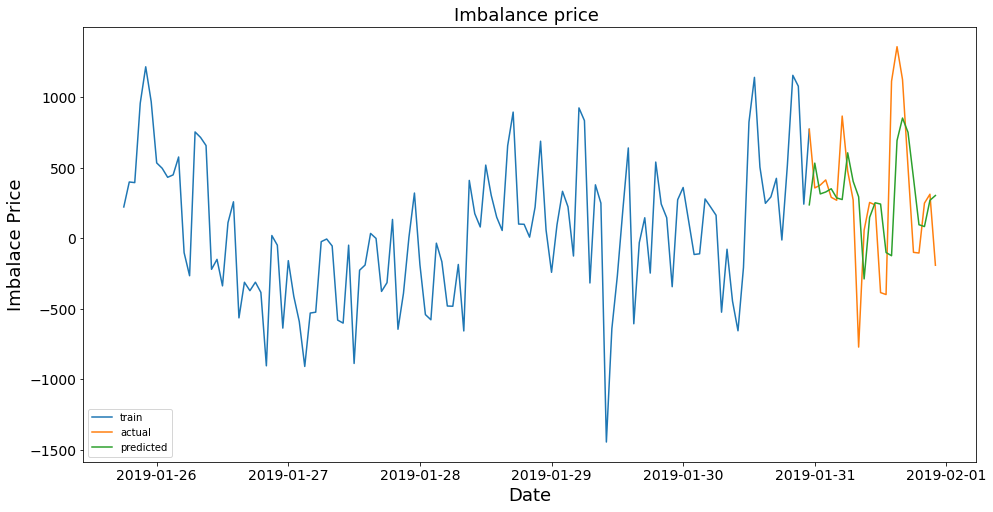

In [233]:
plot_forecast(train_jan,  forecasts_1h_jan)

In [203]:
aic_jun = best_aic(train_june, p_range, d_range, q_range)

(1, 1, 1) 22128.92797987238
(1, 1, 2) 22089.745905851956
(1, 1, 3) 22096.0832110964
(2, 1, 1) 22104.727758684814
(2, 1, 2) 22089.272992844883
(2, 1, 3) 22092.992132836207
(3, 1, 1) 22087.60115253723
(3, 1, 2) 22088.12102178006
(3, 1, 3) 22092.201768152583


1,1,2 could be selected as the best values for p,d,q respectively 

In [206]:
forecasts_1h_june = []
for i in range(24):
    model_1h_june = ARIMA(train_june.iloc[:-(25-i),:], order=(1,1,2))
    model_1h_fit_june = model_1h_june.fit()
    forecast_1h_june = model_1h_fit_june.forecast(steps=1)
    print(forecast_1h_june)
    forecasts_1h_june.append(forecast_1h_june)

2019-07-30 23:00:00   -137.970909
Freq: H, dtype: float64
2019-07-31   -96.261106
Freq: H, dtype: float64
2019-07-31 01:00:00   -1.91021
Freq: H, dtype: float64
2019-07-31 02:00:00   -225.891652
Freq: H, dtype: float64
2019-07-31 03:00:00   -64.85471
Freq: H, dtype: float64
2019-07-31 04:00:00    4.778478
Freq: H, dtype: float64
2019-07-31 05:00:00   -338.306357
Freq: H, dtype: float64
2019-07-31 06:00:00   -211.352263
Freq: H, dtype: float64
2019-07-31 07:00:00   -72.346669
Freq: H, dtype: float64
2019-07-31 08:00:00   -31.265422
Freq: H, dtype: float64
2019-07-31 09:00:00   -419.480241
Freq: H, dtype: float64
2019-07-31 10:00:00    241.727187
Freq: H, dtype: float64
2019-07-31 11:00:00   -49.365468
Freq: H, dtype: float64
2019-07-31 12:00:00   -273.879919
Freq: H, dtype: float64
2019-07-31 13:00:00   -433.212419
Freq: H, dtype: float64
2019-07-31 14:00:00   -301.582006
Freq: H, dtype: float64
2019-07-31 15:00:00   -119.556753
Freq: H, dtype: float64
2019-07-31 16:00:00   -127.969346


rmse =  499.5747031426609


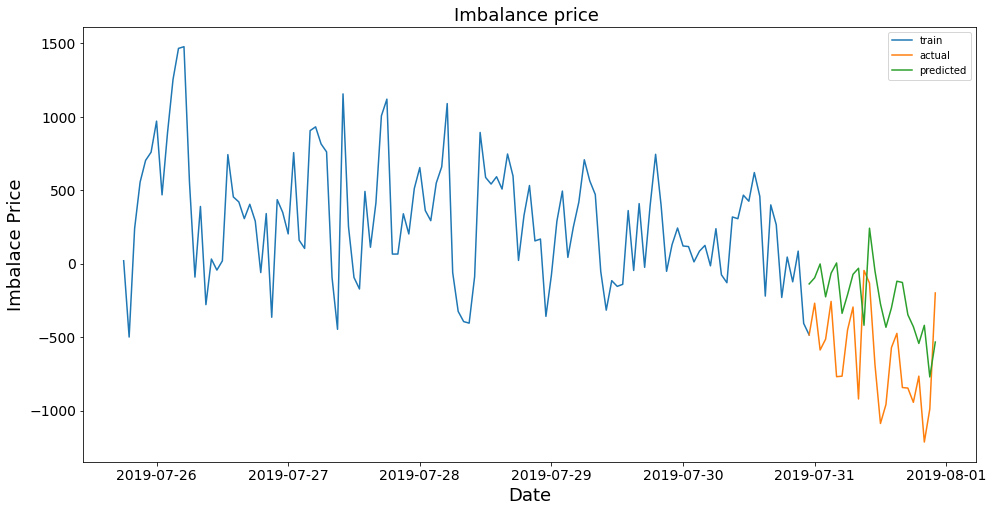

In [234]:
plot_forecast(train_june,  forecasts_1h_june)

In [204]:
aic_sep = best_aic(train_sep, p_range, d_range, q_range)

(1, 1, 1) 21364.138999860428
(1, 1, 2) 21352.742411707306
(1, 1, 3) 21354.052205521963
(2, 1, 1) 21361.085414714504
(2, 1, 2) 21350.092184739904
(2, 1, 3) 21340.92892678044
(3, 1, 1) 21340.815614810188
(3, 1, 2) 21342.479233996954
(3, 1, 3) 21342.96056297978


best parameters : 2,1,3

In [207]:
forecasts_1h_sep = []
for i in range(24):
    model_1h_sep = ARIMA(train_sep.iloc[:-(25-i),:], order=(2,1,3))
    model_1h_fit_sep = model_1h_sep.fit()
    forecast_1h_sep = model_1h_fit_sep.forecast(steps=1)
    print(forecast_1h_sep)
    forecasts_1h_sep.append(forecast_1h_sep)

2019-10-30 23:00:00   -8.699789
Freq: H, dtype: float64
2019-10-31    147.048144
Freq: H, dtype: float64
2019-10-31 01:00:00    131.49213
Freq: H, dtype: float64
2019-10-31 02:00:00    109.386027
Freq: H, dtype: float64
2019-10-31 03:00:00    81.338464
Freq: H, dtype: float64
2019-10-31 04:00:00    41.356263
Freq: H, dtype: float64
2019-10-31 05:00:00   -10.294113
Freq: H, dtype: float64
2019-10-31 06:00:00   -41.558671
Freq: H, dtype: float64
2019-10-31 07:00:00   -55.251596
Freq: H, dtype: float64
2019-10-31 08:00:00    110.626009
Freq: H, dtype: float64
2019-10-31 09:00:00   -14.039709
Freq: H, dtype: float64
2019-10-31 10:00:00   -156.127926
Freq: H, dtype: float64
2019-10-31 11:00:00   -195.875361
Freq: H, dtype: float64
2019-10-31 12:00:00   -269.730576
Freq: H, dtype: float64
2019-10-31 13:00:00   -71.737084
Freq: H, dtype: float64
2019-10-31 14:00:00   -38.008621
Freq: H, dtype: float64
2019-10-31 15:00:00   -126.025412
Freq: H, dtype: float64
2019-10-31 16:00:00   -71.130381
F

rmse =  372.00844408927736


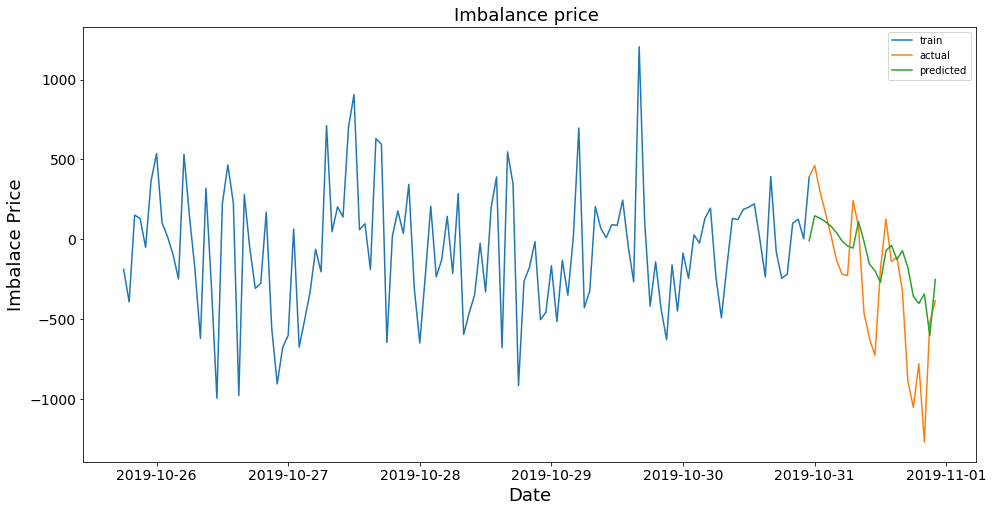

In [235]:
plot_forecast(train_sep,  forecasts_1h_sep)